# Introduction

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np

# Stats
import statsmodels.tsa.stattools # for ADF test and coint function
import statsmodels.api # for OLS

# from scipy.stats import norm  # to fit normal dist to data
# import matplotlib.mlab as mlab  # to generate pdfs

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

This report summarises and demonstrates some of the techniques used at arriving at trading strategies using the concepts of _stationarity_ and _cointegration_. In particular, the focus is on energy commodities.

* Section 1 provides details for the datasets used throughout the report
* Section 2 introduces the concept of Stationarity in time series, which  is the key property exploited by cointegration techniques and mean-reverting strategies
* Section 3 goes in detail about Cointegration and how to test for it, as well as assesing its significance
* Section 4 is then dedicated to the application of these concepts to trading strategies and assesing their performance in terms of profit and loss
* Finally the Appendix summarises some of the mathematical methods involved such as Multivariate Regression models (VAR(p), ECM, Augmented Dickey-Fuller Test and Ornstein–Uhlenbeck processes

# Datasets

## Simulated Data

Unless otherwise stated, stochastic processes are simulated with Monte Carlo (MC) where random samples are drawn from the normal distribution.

## Real Data

* For simplicity, only two finacial series are used to demonstrate the concepts. As the focus is on energy commodities, Brent crude and a byproduct (Low Sulphur Gasoil) were selected since they were assumed to be good candidates to demonstrate cointegration 
* The [Brent](https://www.theice.com/products/219/Brent-Crude-Futures) and [Gasoil](https://www.theice.com/products/34361119/Low-Sulphur-Gasoil-Futures) Futures prices traded in the Intercontinental Exchange (ICE) were taken from  [Quandl's Steven Continuous Series](https://www.quandl.com/data/SCF/documentation/about) using the 'Roll on Last Trading Day with No Price Adjustment' version and the 'Settle' field
* The two series were joined to produce a single dataset consisting of daily settlement prices for Brent and Gasoil from January 2010 to June 2016
* Dates with missing values after joining the two series were dropped
* Since Gasoil is traded in metric tons and Brent in barrels, the gasoil series was divided by 7.45, which is the [ICE conversion factor](https://www.theice.com/publicdocs/futures/ICE_Gas_Oil_Crack.pdf)

The figure below shows the resulting dataset, where the two series indeed seem to be closely related and having with parallel up and down trends.

            brent     gasoil
Date                        
2010-01-04  80.12  87.751678
2010-01-05  80.59  88.489933
2010-01-06  81.89  88.825503
2010-01-07  81.51  88.624161
2010-01-08  81.37  88.087248
            brent     gasoil
Date                        
2016-06-24  48.41  58.389262
2016-06-27  47.16  56.476510
2016-06-28  48.58  57.516779
2016-06-29  50.61  60.402685
2016-06-30  49.68  59.395973


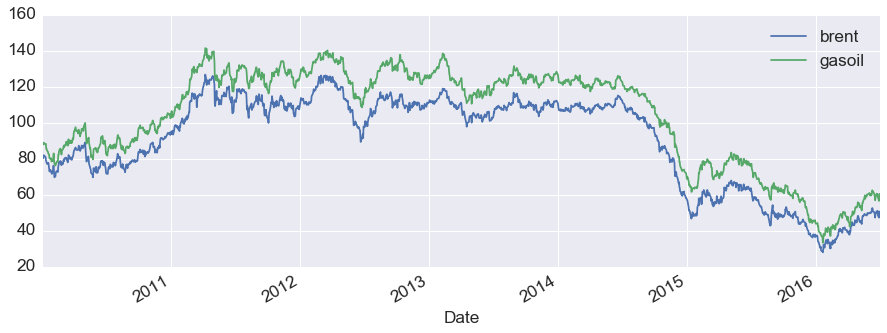

In [11]:
temp = pd.read_csv("data/df_brent_gasoil.csv", index_col=0, parse_dates=True, dayfirst=True)
df = temp[temp.index > datetime(2010, 1, 1)]
print df.head()
print df.tail()
_ = df.plot()

# Stationarity and Mean-Reversion

Before cointegration is introduced, it is important to understand the concept of stationarity. A time series is stationary when the parameters of its generating process do not change over time. In particular, its long-run mean and variance stay constant. This property is fundamental when applying linear regression and forecasting models.

Processes with a drift or trend, like stock prices, are non-stationary, but can be transformed to become stationary. For example, by differencing prices, we get returns, which are in general stationary.

The figure below shows how a simulated random walk with drift $Y_t = \alpha + Y_{t-1} + \epsilon_t$ can be made stationary by differencing $Y_t - Y_{t-1} = \alpha + \epsilon_t$

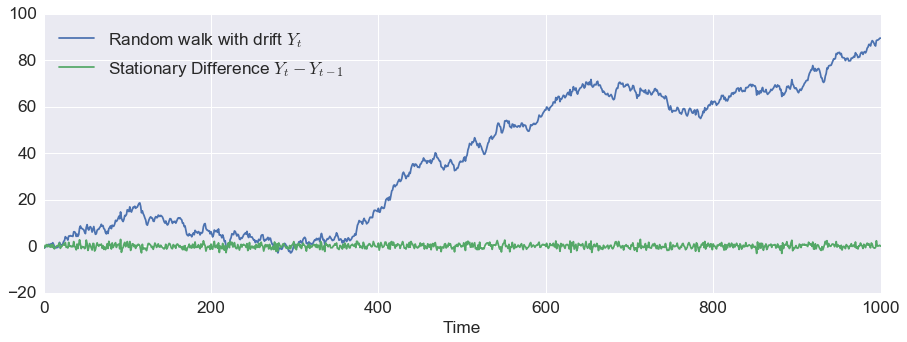

In [122]:
np.random.seed(1000)  # set the seed
M = 1000  # no. of time steps
Y_t = np.zeros((M + 1))
Y_t[0] = 0.0  # initial value
a = 0.1  # drift

for i in xrange(1, M + 1, 1):
    Y_t[i] = a + Y_t[i-1] + np.random.normal(0, 1)

# Y_t = pd.Series(index=range(M), data=Y_t)
Y_t = pd.Series(Y_t)
_ = Y_t.plot()
_ = Y_t.diff().plot()
# _ = plt.ylabel('Series Value')
_ = plt.xlabel('Time')
_ = plt.legend(['Random walk with drift $Y_t$', 'Stationary Difference $Y_t - Y_{t-1}$'], loc='upper left')

## Mean-Reversion

A stationary series is mean-reverting if over time it drifts towards its long-term mean (the historical equilibrium level). A popular model in this category is the Ornstein–Uhlenbeck (OU) process:

$$
dY_t = \theta(\mu - Y_t)dt + \sigma dW_t
$$

where $\theta$ is the speed of reversion, $\mu$ is the equilibrium level, $\sigma$ the variance and $W_t$ a Wiener Process (Brownian Motion). In a discrete setting this  states that the change in the price over the next time period is proportional to the difference between the mean price and the current price. This is in contrast to a random walk (Brownian motion), which has no "memory" of where it has been at each particular instance of time. 

The figure below shows the OU process for different speeds of mean-reversion.

In [164]:
import math
from math import exp, sqrt, log

# MC params
np.random.seed(1000)  # set the seed
dt = 1  # time step
M = 1000  # no. of time steps

# Model params:
mu = 3
sigma = 0.2

Y_t1 = np.zeros((M + 1))
Y_t2 = np.zeros((M + 1))
Y_t3 = np.zeros((M + 1))

Y_t1[0] = -50.0
Y_t2[0] = 50.0
Y_t3[0] = 0.0

theta1 = 0.003
theta2 = 0.01
theta3 = 0.1

for i in xrange(1, M + 1, 1):
    Y_t1[i] = Y_t1[i-1] + theta1 * (mu - Y_t1[i-1]) * dt + sigma * math.sqrt(dt) * np.random.normal(0, 1)
    dY[i] = Y_t1[i] - Y_t1[i-1]
    Y_t2[i] = Y_t2[i-1] + theta2 * (mu - Y_t2[i-1]) * dt + sigma * math.sqrt(dt) * np.random.normal(0, 1)
    Y_t3[i] = Y_t3[i-1] + theta3 * (mu - Y_t3[i-1]) * dt + sigma * math.sqrt(dt) * np.random.normal(0, 1)

# Y_t = pd.Series(index=range(M), data=Y_t)
Y_t1 = pd.Series(Y_t1)
Y_t2 = pd.Series(Y_t2)
Y_t3 = pd.Series(Y_t3)

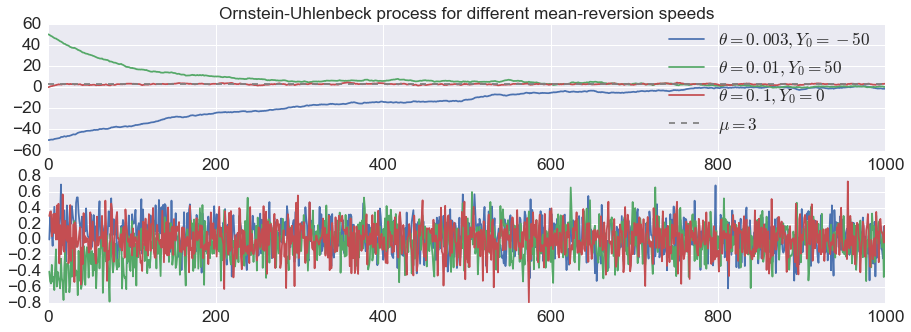

In [169]:
plt.figure(1)
plt.subplot(211)
_ = Y_t1.plot()
_ = Y_t2.plot()
_ = Y_t3.plot()

_ = plt.axhline(mu, color='grey', linestyle='--') 

# _ = plt.ylabel('Series Value')
plt.title('Ornstein-Uhlenbeck process for different mean-reversion speeds')
_ = plt.xlabel('Time')
_ = plt.legend([r'$\theta={0}, Y_0={1:0.0f}$'.format(theta1, Y_t1[0]), 
                r'$\theta={0}, Y_0={1:0.0f}$'.format(theta2, Y_t2[0]), 
                r'$\theta={0}, Y_0={1:0.0f}$'.format(theta3, Y_t3[0]), 
                r'$\mu={0}$'.format(mu)], 
               loc='lower right')

plt.subplot(212)
Y_t1.diff().plot()
Y_t2.diff().plot()
Y_t3.diff().plot()

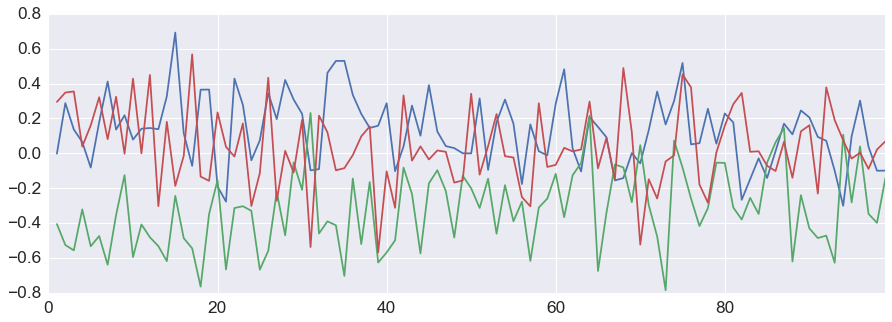

In [158]:
Y_t1.diff()[0:100].plot()
Y_t2.diff()[0:100].plot()
Y_t3.diff()[0:100].plot()

In [160]:
print Y_t1.diff().mean()
print Y_t2.diff().mean()
print Y_t3.diff().mean()

0.0483688498663
-0.0499270504531
0.00329153741397


The mean-reverting property of a time series can be exploited in order to produce profitable trading strategies.

Additional mathematical details can be found in the Appendix.

## Simulated Data Example

## Real Data Example

## Tests

### Augmented Dickey-Fuller (ADF)